## 2D Grid Search

--- Step 1: Loading data ---
Data loading completed.
--- Step 2: Interpolating SIDC monthly data to daily frequency ---
SIDC data interpolation completed.
--- Step 3: Extracting peaks and valleys from original data ---
Found 12 peaks and 15 valleys from original daily data
--- Step 4: Defining grid search parameters ---
Will search 20 Lambda values and 9 p values (total 180 combinations)
--- Step 5: Starting grid search... ---
Grid search execution completed.
--- Step 6: Analyzing results (Normalized Composite Cost Algorithm - Updated Peak/Valley Weights) ---
Weight settings: peaks/valleys=60.0%, original R²=25.0%, SIDC R²=15.0%
P1 (peaks/valleys) internal weights: peaks=45%, valleys=55%

--- Complete Evaluation Results (sorted by *composite cost*) ---
     lambda      p  total_cost  loss_peak_avg  r2_original  r2_sidc_interp  peak_phase_dev_sidc  valley_phase_dev_sidc  peak_phase_dev_orig  valley_phase_dev_orig
112   78.5M 0.5000      0.0328        52.6500       0.6978          0.9977

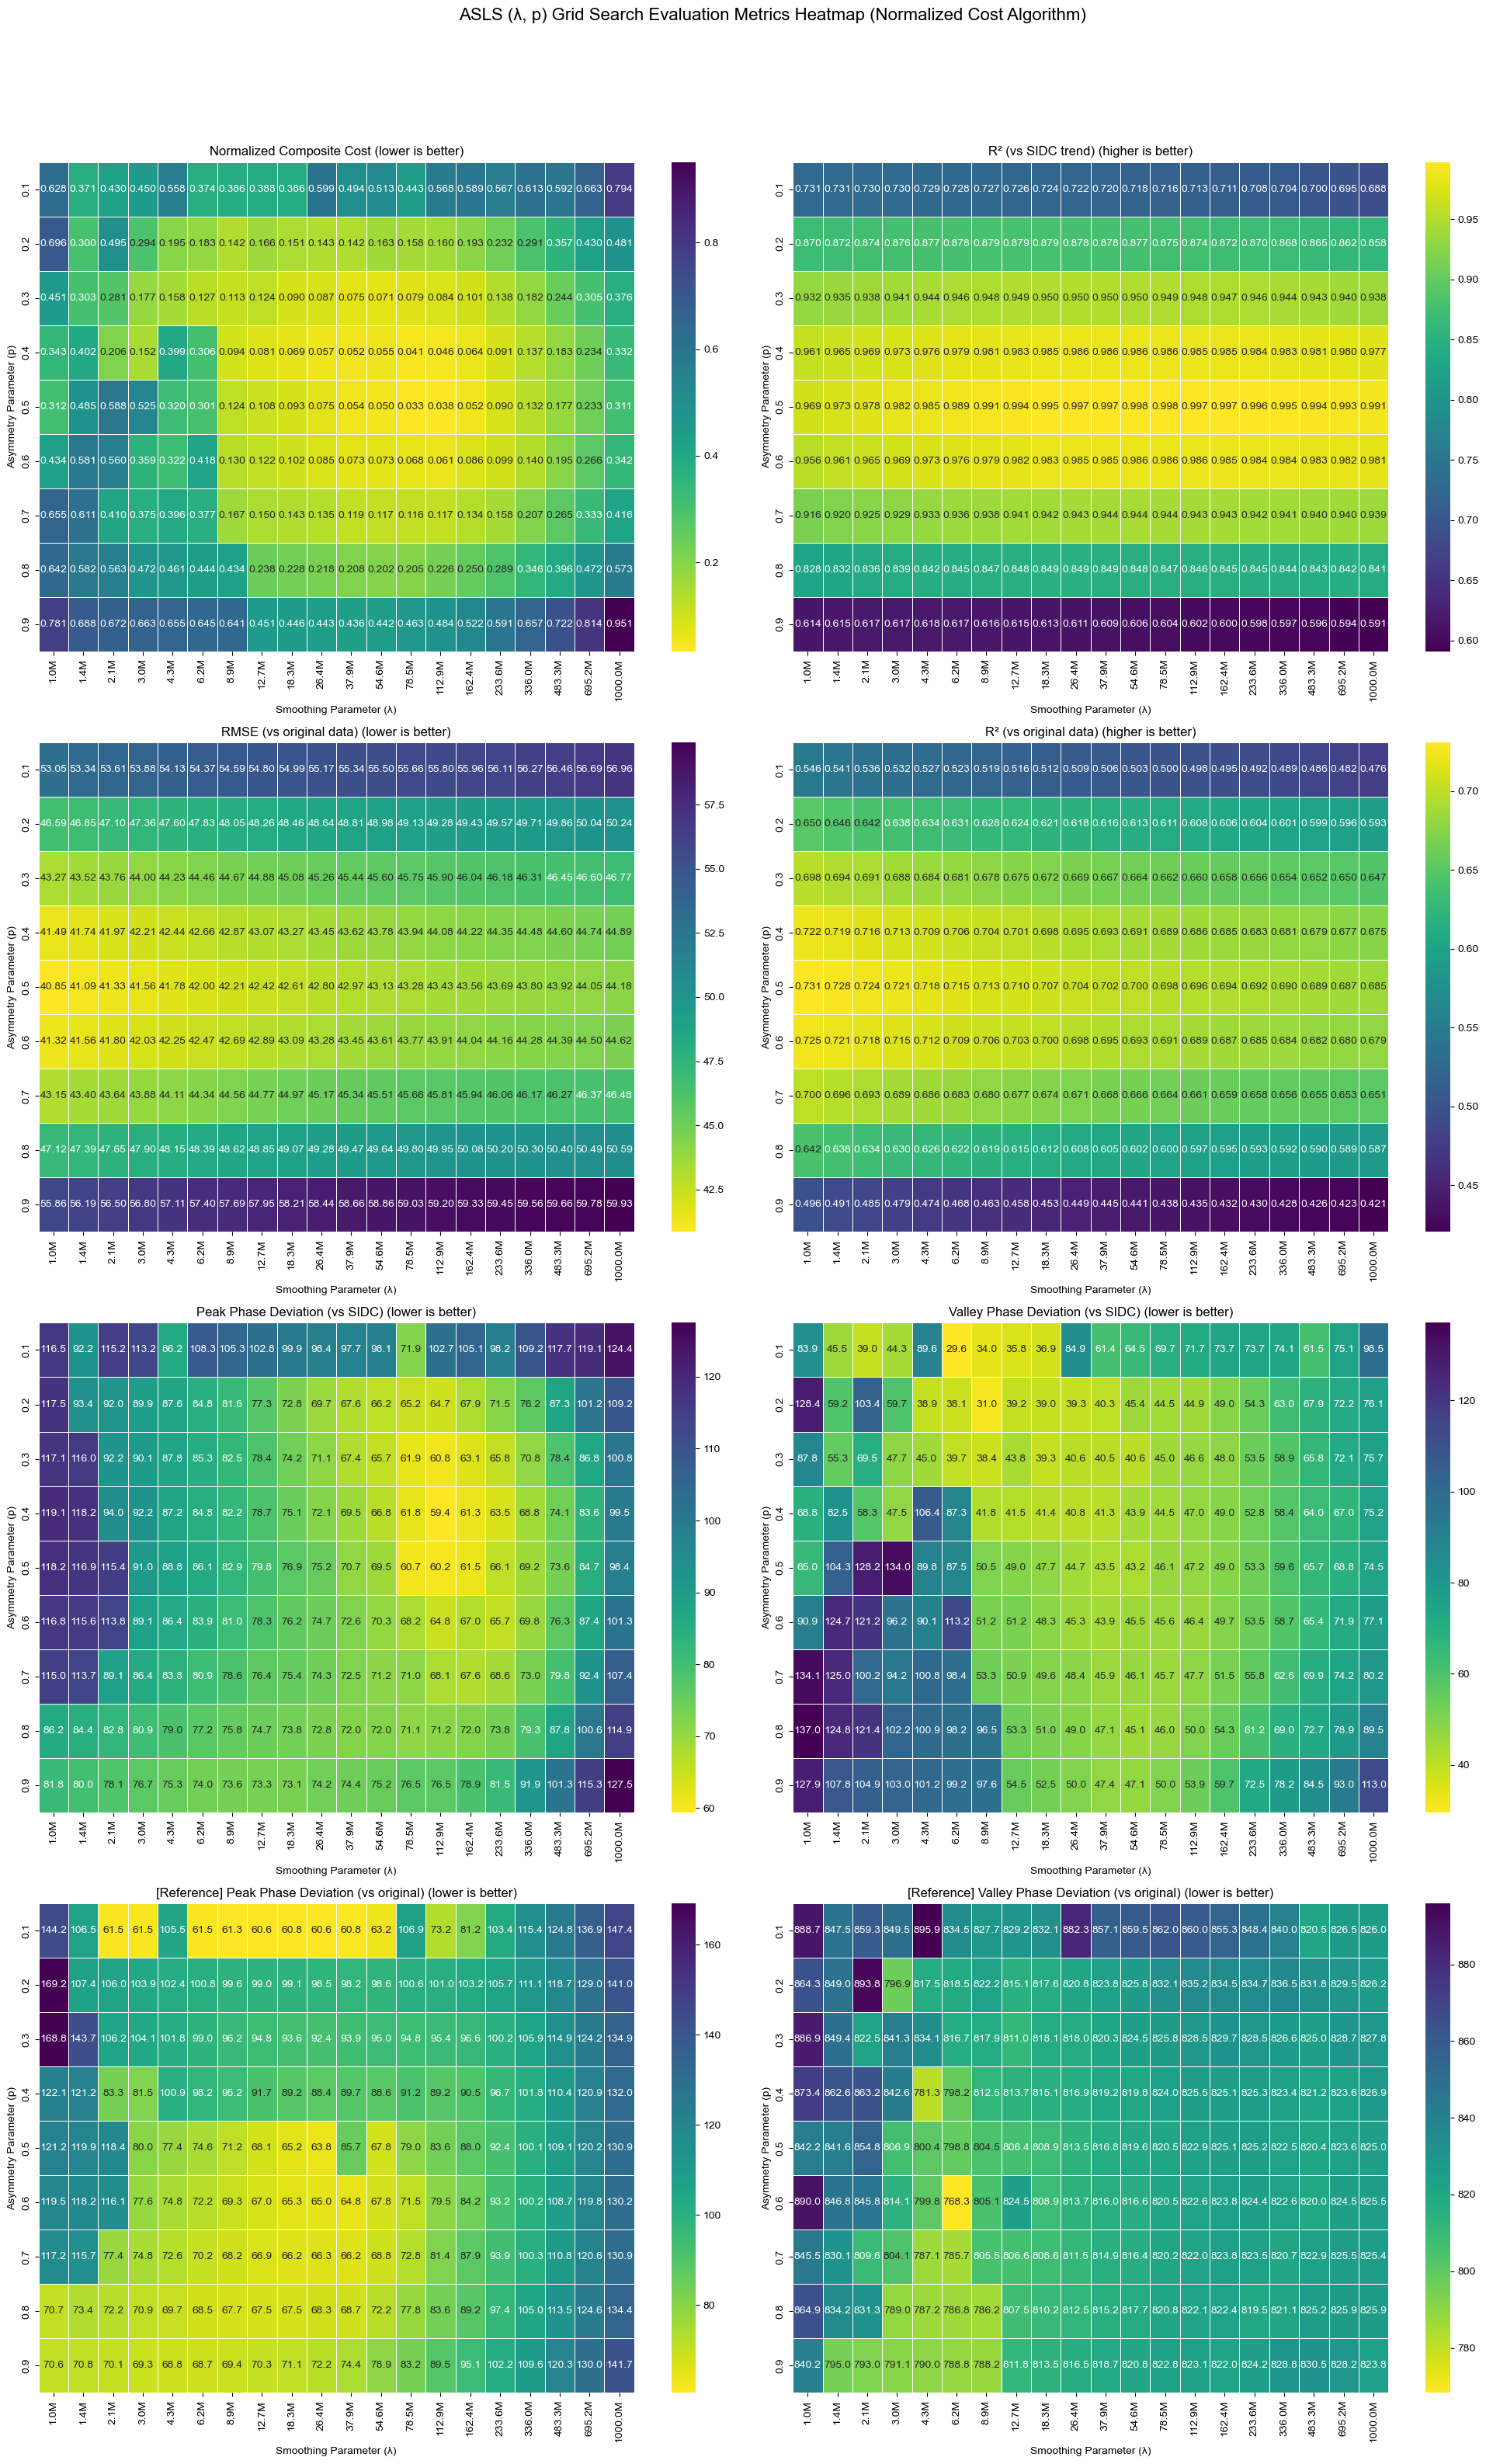


Analysis completed.


In [14]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pybaselines.whittaker import asls
from scipy.interpolate import interp1d
from scipy.signal import find_peaks
from sklearn.metrics import r2_score, mean_squared_error
# Import normalization tools
from sklearn.preprocessing import MinMaxScaler
import sys
import warnings
import seaborn as sns 

warnings.filterwarnings('ignore')

# --------------------------------------------------------------------------
# 1. Helper Functions
# --------------------------------------------------------------------------

def find_peaks_valleys(data_series: pd.Series, 
                       distance_days: int = 365 * 8, 
                       prominence_peaks: int = 40,   
                       prominence_valleys: int = 5): 
    """
    Find peaks and valleys in time series data.
    """
    peaks_idx, _ = find_peaks(data_series, distance=distance_days, prominence=prominence_peaks)
    df_peaks = pd.DataFrame({
        'date': data_series.index[peaks_idx],
        'SSN': data_series.iloc[peaks_idx]
    }).set_index('date')

    valleys_idx, _ = find_peaks(-data_series, distance=distance_days, prominence=prominence_valleys)
    df_valleys = pd.DataFrame({
        'date': data_series.index[valleys_idx],
        'SSN': data_series.iloc[valleys_idx]
    }).set_index('date')

    return df_peaks, df_valleys

def calculate_deviation_vs_known_extrema(model_extrema: pd.DataFrame, 
                                           known_extrema: pd.DataFrame,
                                           tolerance_days: int = 365 * 5):
    """
    Calculate the average phase deviation (in days) between model-detected extrema 
    and SIDC official known extrema.
    """
    if model_extrema.empty or known_extrema.empty:
        return np.nan 

    left_df = model_extrema.sort_index().reset_index().rename(
        columns={'date': 'model_date', 'index': 'model_date'}
    )
    right_df = known_extrema.sort_index().reset_index().rename(
        columns={'date': 'known_date', 'index': 'known_date'}
    )
    
    if 'model_date' not in left_df.columns or 'known_date' not in right_df.columns:
        return np.nan

    merged_df = pd.merge_asof(
        left_df, right_df,
        left_on='model_date', right_on='known_date',
        direction='nearest', 
        tolerance=pd.Timedelta(days=tolerance_days)
    ).dropna()

    if merged_df.empty:
        return np.nan

    merged_df['phase_deviation_days'] = (merged_df['model_date'] - merged_df['known_date']).dt.days
    return np.abs(merged_df['phase_deviation_days']).mean()

# --------------------------------------------------------------------------
# 2. Data Loading and Preprocessing
# --------------------------------------------------------------------------
print("--- Step 1: Loading data ---")
START_DATE = '1855-12-01'
END_DATE = '1986-09-01'

try:
    # [Note] Path is relative to the notebook
    daily_df = pd.read_csv('../../data/ready/ssn_daily_1849_2025.csv')
    daily_df['date'] = pd.to_datetime(daily_df['date'])
    daily_df.set_index('date', inplace=True)
    daily_df.rename(columns={'ssn': 'sunspot_number'}, inplace=True)
    daily_df = daily_df.loc[START_DATE:END_DATE]
    daily_series = daily_df['sunspot_number'][daily_df['sunspot_number'] != -1]

    monthly_df = pd.read_csv('../../data/ready/ssn_smoothed_monthly_1749_2025.csv')
    monthly_df['date'] = pd.to_datetime(monthly_df['Year'].astype(int).astype(str) + '-' + monthly_df['Month'].astype(int).astype(str) + '-01')
    monthly_df.set_index('date', inplace=True)
    monthly_df.rename(columns={'SSN': 'smoothed_number'}, inplace=True)
    monthly_df = monthly_df.loc[START_DATE:END_DATE]
    monthly_sidc = monthly_df['smoothed_number'][monthly_df['smoothed_number'] != -1]

    df_solar_cycle = pd.read_csv('../../data/ready/solar_cycle_minmax.csv')
    known_peaks = df_solar_cycle.dropna(subset=['Max']).set_index(pd.to_datetime(df_solar_cycle['Max']))[['Max_SSN']].rename(columns={'Max_SSN': 'SSN'})
    known_valleys = df_solar_cycle.dropna(subset=['start_Min']).set_index(pd.to_datetime(df_solar_cycle['start_Min']))[['Min_SSN']].rename(columns={'Min_SSN': 'SSN'})
    known_peaks.index.name = 'date'
    known_valleys.index.name = 'date'
    known_peaks = known_peaks.loc[START_DATE:END_DATE]
    known_valleys = known_valleys.loc[START_DATE:END_DATE]

    print("Data loading completed.")
    
    # --------------------------------------------------------------------------
    # 3. Interpolate SIDC monthly data to daily
    # --------------------------------------------------------------------------
    print("--- Step 2: Interpolating SIDC monthly data to daily frequency ---")
    x_monthly = monthly_sidc.index.astype(np.int64)
    y_monthly = monthly_sidc.values
    f_interp = interp1d(x_monthly, y_monthly, kind='linear', fill_value="extrapolate")
    x_daily = daily_series.index.astype(np.int64)
    y_daily_interp = f_interp(x_daily)
    sidc_daily_interp = pd.Series(y_daily_interp, index=daily_series.index)
    print("SIDC data interpolation completed.")

    # --------------------------------------------------------------------------
    # 4. Extract peaks and valleys from original data
    # --------------------------------------------------------------------------
    print("--- Step 3: Extracting peaks and valleys from original data ---")
    # This step is crucial as the baseline for subsequent comparisons
    daily_peaks, daily_valleys = find_peaks_valleys(daily_series)
    print(f"Found {len(daily_peaks)} peaks and {len(daily_valleys)} valleys from original daily data")


except Exception as e:
    print(f"Error during data loading or interpolation: {e}")
    # sys.exit() # Comment out in notebook to avoid stopping kernel

# --------------------------------------------------------------------------
# 5. Define 2D Grid Search
# --------------------------------------------------------------------------
print("--- Step 4: Defining grid search parameters ---")

# Parameter ranges
lam_values = np.logspace(np.log10(1e6), np.log10(1e9), 20) 
p_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9] 

print(f"Will search {len(lam_values)} Lambda values and {len(p_values)} p values (total {len(lam_values) * len(p_values)} combinations)")

# --------------------------------------------------------------------------
# 6. Execute Grid Search
# --------------------------------------------------------------------------
print("--- Step 5: Starting grid search... ---")
grid_search_results = []
total_combinations = len(lam_values) * len(p_values)
count = 0

for lam in lam_values:
    for p in p_values:
        count += 1
        # print(f"  Processing: {count}/{total_combinations} (lambda={lam:,.0f}, p={p:.2f})", end="... ")
        
        try:
            # 1. Run ASLS smoothing
            smoothed_data, _ = asls(daily_series.values, lam=lam, p=p)
            smoothed_series = pd.Series(smoothed_data, index=daily_series.index)

            # 2. Evaluation metrics (vs original data)
            rmse_original = np.sqrt(mean_squared_error(daily_series.values, smoothed_data))
            r2_original = r2_score(daily_series.values, smoothed_data) 

            # 3. Evaluation metrics (vs SIDC interpolated data)
            r2_sidc_interp = r2_score(sidc_daily_interp.values, smoothed_data)
            rmse_sidc_interp = np.sqrt(mean_squared_error(sidc_daily_interp.values, smoothed_data)) 
            
            # 4. Find peaks and valleys in smoothed curve
            smoothed_peaks, smoothed_valleys = find_peaks_valleys(smoothed_series)
            
            # 5. Evaluation metric: phase deviation (vs SIDC official points)
            peak_phase_dev_sidc = calculate_deviation_vs_known_extrema(smoothed_peaks, known_peaks)
            valley_phase_dev_sidc = calculate_deviation_vs_known_extrema(smoothed_valleys, known_valleys)
            
            # 6. Evaluation metric: phase deviation (vs original data peaks/valleys)
            peak_phase_dev_orig = calculate_deviation_vs_known_extrema(smoothed_peaks, daily_peaks)
            valley_phase_dev_orig = calculate_deviation_vs_known_extrema(smoothed_valleys, daily_valleys)


            grid_search_results.append({
                'lambda': lam,
                'p': p,
                'r2_original': r2_original,       
                'rmse_original': rmse_original,
                'r2_sidc_interp': r2_sidc_interp,
                'rmse_sidc_interp': rmse_sidc_interp, 
                'peak_phase_dev_sidc': peak_phase_dev_sidc,
                'valley_phase_dev_sidc': valley_phase_dev_sidc,
                'peak_phase_dev_orig': peak_phase_dev_orig,
                'valley_phase_dev_orig': valley_phase_dev_orig
            })
            # print("Done")
            
        except Exception as e:
            print(f"Failed (error: {e})")
            grid_search_results.append({
                'lambda': lam, 'p': p,
                'r2_original': np.nan, 'rmse_original': np.nan, 
                'r2_sidc_interp': np.nan, 'rmse_sidc_interp': np.nan,
                'peak_phase_dev_sidc': np.nan, 'valley_phase_dev_sidc': np.nan,
                'peak_phase_dev_orig': np.nan, 'valley_phase_dev_orig': np.nan
            })

print("Grid search execution completed.")

# --------------------------------------------------------------------------
# 7. Analyze Results (V7 - Normalized Composite Cost Algorithm - Updated Peak/Valley Weights)
# --------------------------------------------------------------------------
print("--- Step 6: Analyzing results (Normalized Composite Cost Algorithm - Updated Peak/Valley Weights) ---")

if not grid_search_results:
    print("Error: No valid search results.")
    # sys.exit()
else:
    # [IMPORTANT] Drop any rows where loss cannot be calculated before normalization
    results_df = pd.DataFrame(grid_search_results).dropna(
        subset=['peak_phase_dev_sidc', 'valley_phase_dev_sidc', 'r2_original', 'r2_sidc_interp']
    )

if results_df.empty:
    print("Error: All combinations failed to calculate metrics.")
    # sys.exit()
else:
    # --- 1. Define priority weights ---
    # (P1=peaks/valleys, P2=R²-orig, P3=R²-sidc)
    # Total must equal 1.0
    W_PEAK = 0.60  # P1 (most important): 60% weight for SIDC peak/valley matching
    W_ORIG = 0.25  # P2 (secondary): 25% weight for R²-original data
    W_SIDC = 0.15  # P3 (balance): 15% weight for R²-SIDC trend
    
    print(f"Weight settings: peaks/valleys={W_PEAK*100}%, original R²={W_ORIG*100}%, SIDC R²={W_SIDC*100}%")

    # --- 2. Define P1 internal peak/valley weights ---
    # Based on theoretical analysis, valleys (cycle boundaries) are more important than peaks (cycle intensity)
    W_PEAK_INTERNAL = 0.45    # Peak deviation accounts for 45% of P1 loss
    W_VALLEY_INTERNAL = 0.55  # Valley deviation accounts for 55% of P1 loss
    print(f"P1 (peaks/valleys) internal weights: peaks={W_PEAK_INTERNAL*100:.0f}%, valleys={W_VALLEY_INTERNAL*100:.0f}%")

    # --- 3. Create three "loss" columns (goal: minimize all) ---
    
    # P1 loss: weighted average peak/valley deviation (days)
    results_df['loss_peak_avg'] = (
        results_df['peak_phase_dev_sidc'] * W_PEAK_INTERNAL + 
        results_df['valley_phase_dev_sidc'] * W_VALLEY_INTERNAL
    )
    
    # P2 loss: 1.0 - R²(original). Lower is better (i.e., higher R² is better)
    results_df['loss_orig_r2'] = 1.0 - results_df['r2_original']
    
    # P3 loss: 1.0 - R²(SIDC). Lower is better (i.e., higher R² is better)
    results_df['loss_sidc_r2'] = 1.0 - results_df['r2_sidc_interp']

    # --- 4. Normalization ---
    # This is the algorithm's core: scaling different magnitudes (days, R² values) to [0, 1] range
    scaler = MinMaxScaler()
    
    results_df['norm_loss_peak'] = scaler.fit_transform(results_df[['loss_peak_avg']])
    results_df['norm_loss_orig'] = scaler.fit_transform(results_df[['loss_orig_r2']])
    results_df['norm_loss_sidc'] = scaler.fit_transform(results_df[['loss_sidc_r2']])

    # --- 5. Calculate final "composite cost" ---
    # Apply weights to normalized losses
    results_df['total_cost'] = (
        results_df['norm_loss_peak'] * W_PEAK +
        results_df['norm_loss_orig'] * W_ORIG +
        results_df['norm_loss_sidc'] * W_SIDC
    )

    # --- 6. Sort and find best parameters ---
    results_df_sorted = results_df.sort_values(by='total_cost', ascending=True)

    best_params = results_df_sorted.iloc[0]

    print("\n--- Complete Evaluation Results (sorted by *composite cost*) ---")
    # Print selected columns for clearer table
    columns_to_show = [
        'lambda', 'p', 'total_cost',
        'loss_peak_avg', 'r2_original', 'r2_sidc_interp',
        'peak_phase_dev_sidc', 'valley_phase_dev_sidc',
        'peak_phase_dev_orig', 'valley_phase_dev_orig'
    ]
    # Format lambda column
    formatted_df = results_df_sorted[columns_to_show].copy()
    formatted_df['lambda'] = formatted_df['lambda'].apply(lambda x: f"{x/1e6:.1f}M")
    
    print(formatted_df.head(20).to_string(float_format="%.4f"))


    print("\n\n--- 🏆 Best Composite Parameter Combination (Normalized Cost Algorithm - Peak/Valley Weighted) ---")
    print(f"Lambda (λ): {best_params['lambda']:.2f}")
    print(f"p:          {best_params['p']:.2f}")
    print(f"Composite cost: {best_params['total_cost']:.4f} (lower is better)")
    print("\nDetailed metrics:")
    print(f"  P1 (SIDC peak/valley weighted deviation): {best_params['loss_peak_avg']:.1f} days")
    print(f"     (peaks: {best_params['peak_phase_dev_sidc']:.1f} days, valleys: {best_params['valley_phase_dev_sidc']:.1f} days)")
    print(f"  P2 (R² vs original data):   {best_params['r2_original']:.4f}")
    print(f"  P3 (R² vs SIDC trend):  {best_params['r2_sidc_interp']:.4f}")
    print("\nOther reference metrics:")
    print(f"  RMSE (vs original data): {best_params['rmse_original']:.2f}")
    print(f"  RMSE (vs SIDC trend):  {best_params['rmse_sidc_interp']:.2f}")
    print(f"  [Reference] Original peak deviation: {best_params['peak_phase_dev_orig']:.1f} days")
    print(f"  [Reference] Original valley deviation: {best_params['valley_phase_dev_orig']:.1f} days")

# --------------------------------------------------------------------------
# 8. Visualize Grid Search Heatmaps
# --------------------------------------------------------------------------
print("\n--- Step 7: Visualizing grid search heatmaps ---")

# Define helper function for plotting to avoid code duplication
def plot_heatmap(ax, data, title, cmap, fmt=".2f"):
    # Format x-axis labels for readability
    data.columns = [f"{x/1e6:.1f}M" if x >= 1e6 else f"{x/1e3:.0f}K" for x in data.columns]
    sns.heatmap(data, ax=ax, annot=True, fmt=fmt, cmap=cmap, linewidths=.5)
    ax.set_title(title, fontsize=12)
    ax.set_xlabel('Smoothing Parameter (λ)')
    ax.set_ylabel('Asymmetry Parameter (p)')

# Create a 4x2 plot panel
fig, axes = plt.subplots(4, 2, figsize=(20, 32))
fig.suptitle('ASLS (λ, p) Grid Search Evaluation Metrics Heatmap (Normalized Cost Algorithm)', fontsize=16, y=1.02)

# --- Plot heatmaps ---
# 1. Composite cost (lower is better)
# Replaced original 'combined_rank'
cost_pivot = results_df.pivot(index='p', columns='lambda', values='total_cost')
plot_heatmap(axes[0, 0], cost_pivot, 'Normalized Composite Cost (lower is better)', 'viridis_r', fmt=".3f")

# 2. R² (vs SIDC interpolated) (higher is better)
r2_sidc_pivot = results_df.pivot(index='p', columns='lambda', values='r2_sidc_interp')
plot_heatmap(axes[0, 1], r2_sidc_pivot, 'R² (vs SIDC trend) (higher is better)', 'viridis', fmt=".3f")

# 3. RMSE (vs original data) (lower is better)
rmse_orig_pivot = results_df.pivot(index='p', columns='lambda', values='rmse_original')
plot_heatmap(axes[1, 0], rmse_orig_pivot, 'RMSE (vs original data) (lower is better)', 'viridis_r', fmt=".2f")

# 4. R² (vs original data) (higher is better)
r2_orig_pivot = results_df.pivot(index='p', columns='lambda', values='r2_original')
plot_heatmap(axes[1, 1], r2_orig_pivot, 'R² (vs original data) (higher is better)', 'viridis', fmt=".3f")

# 5. Peak phase deviation (vs SIDC) (lower is better)
peak_dev_sidc_pivot = results_df.pivot(index='p', columns='lambda', values='peak_phase_dev_sidc')
plot_heatmap(axes[2, 0], peak_dev_sidc_pivot, 'Peak Phase Deviation (vs SIDC) (lower is better)', 'viridis_r', fmt=".1f")

# 6. Valley phase deviation (vs SIDC) (lower is better)
valley_dev_sidc_pivot = results_df.pivot(index='p', columns='lambda', values='valley_phase_dev_sidc')
plot_heatmap(axes[2, 1], valley_dev_sidc_pivot, 'Valley Phase Deviation (vs SIDC) (lower is better)', 'viridis_r', fmt=".1f")

# 7. Peak phase deviation (vs original) (lower is better)
peak_dev_orig_pivot = results_df.pivot(index='p', columns='lambda', values='peak_phase_dev_orig')
plot_heatmap(axes[3, 0], peak_dev_orig_pivot, '[Reference] Peak Phase Deviation (vs original) (lower is better)', 'viridis_r', fmt=".1f")

# 8. Valley phase deviation (vs original) (lower is better)
valley_dev_orig_pivot = results_df.pivot(index='p', columns='lambda', values='valley_phase_dev_orig')
plot_heatmap(axes[3, 1], valley_dev_orig_pivot, '[Reference] Valley Phase Deviation (vs original) (lower is better)', 'viridis_r', fmt=".1f")


plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()

print("\nAnalysis completed.")


## p_values=0.5 confirmed as optimal, now exploring lam_values

--- Preparation: Libraries and assumed functions/data are ready ---
--- Helper function 'robust_find_peaks_valleys' defined ---
--- Step 1: Defining new search parameters and weights ---
Fixed p = 0.5
Will search 1000 Lambda values (from 1e+06 to 1e+09)
Algorithm weights: peaks/valleys=60.0%, original R²=25.0%, SIDC R²=15.0%

--- Step 2: Starting fine search ---


Processing Lambda (p=0.5):   0%|          | 0/1000 [00:00<?, ?it/s]


--- Step 3: Search completed, starting algorithm and visualization ---
Total 1000 results, 1000 valid results for algorithm analysis.
Normalized composite cost (total_cost) calculation completed.
--- Step 4: Plotting line charts ---


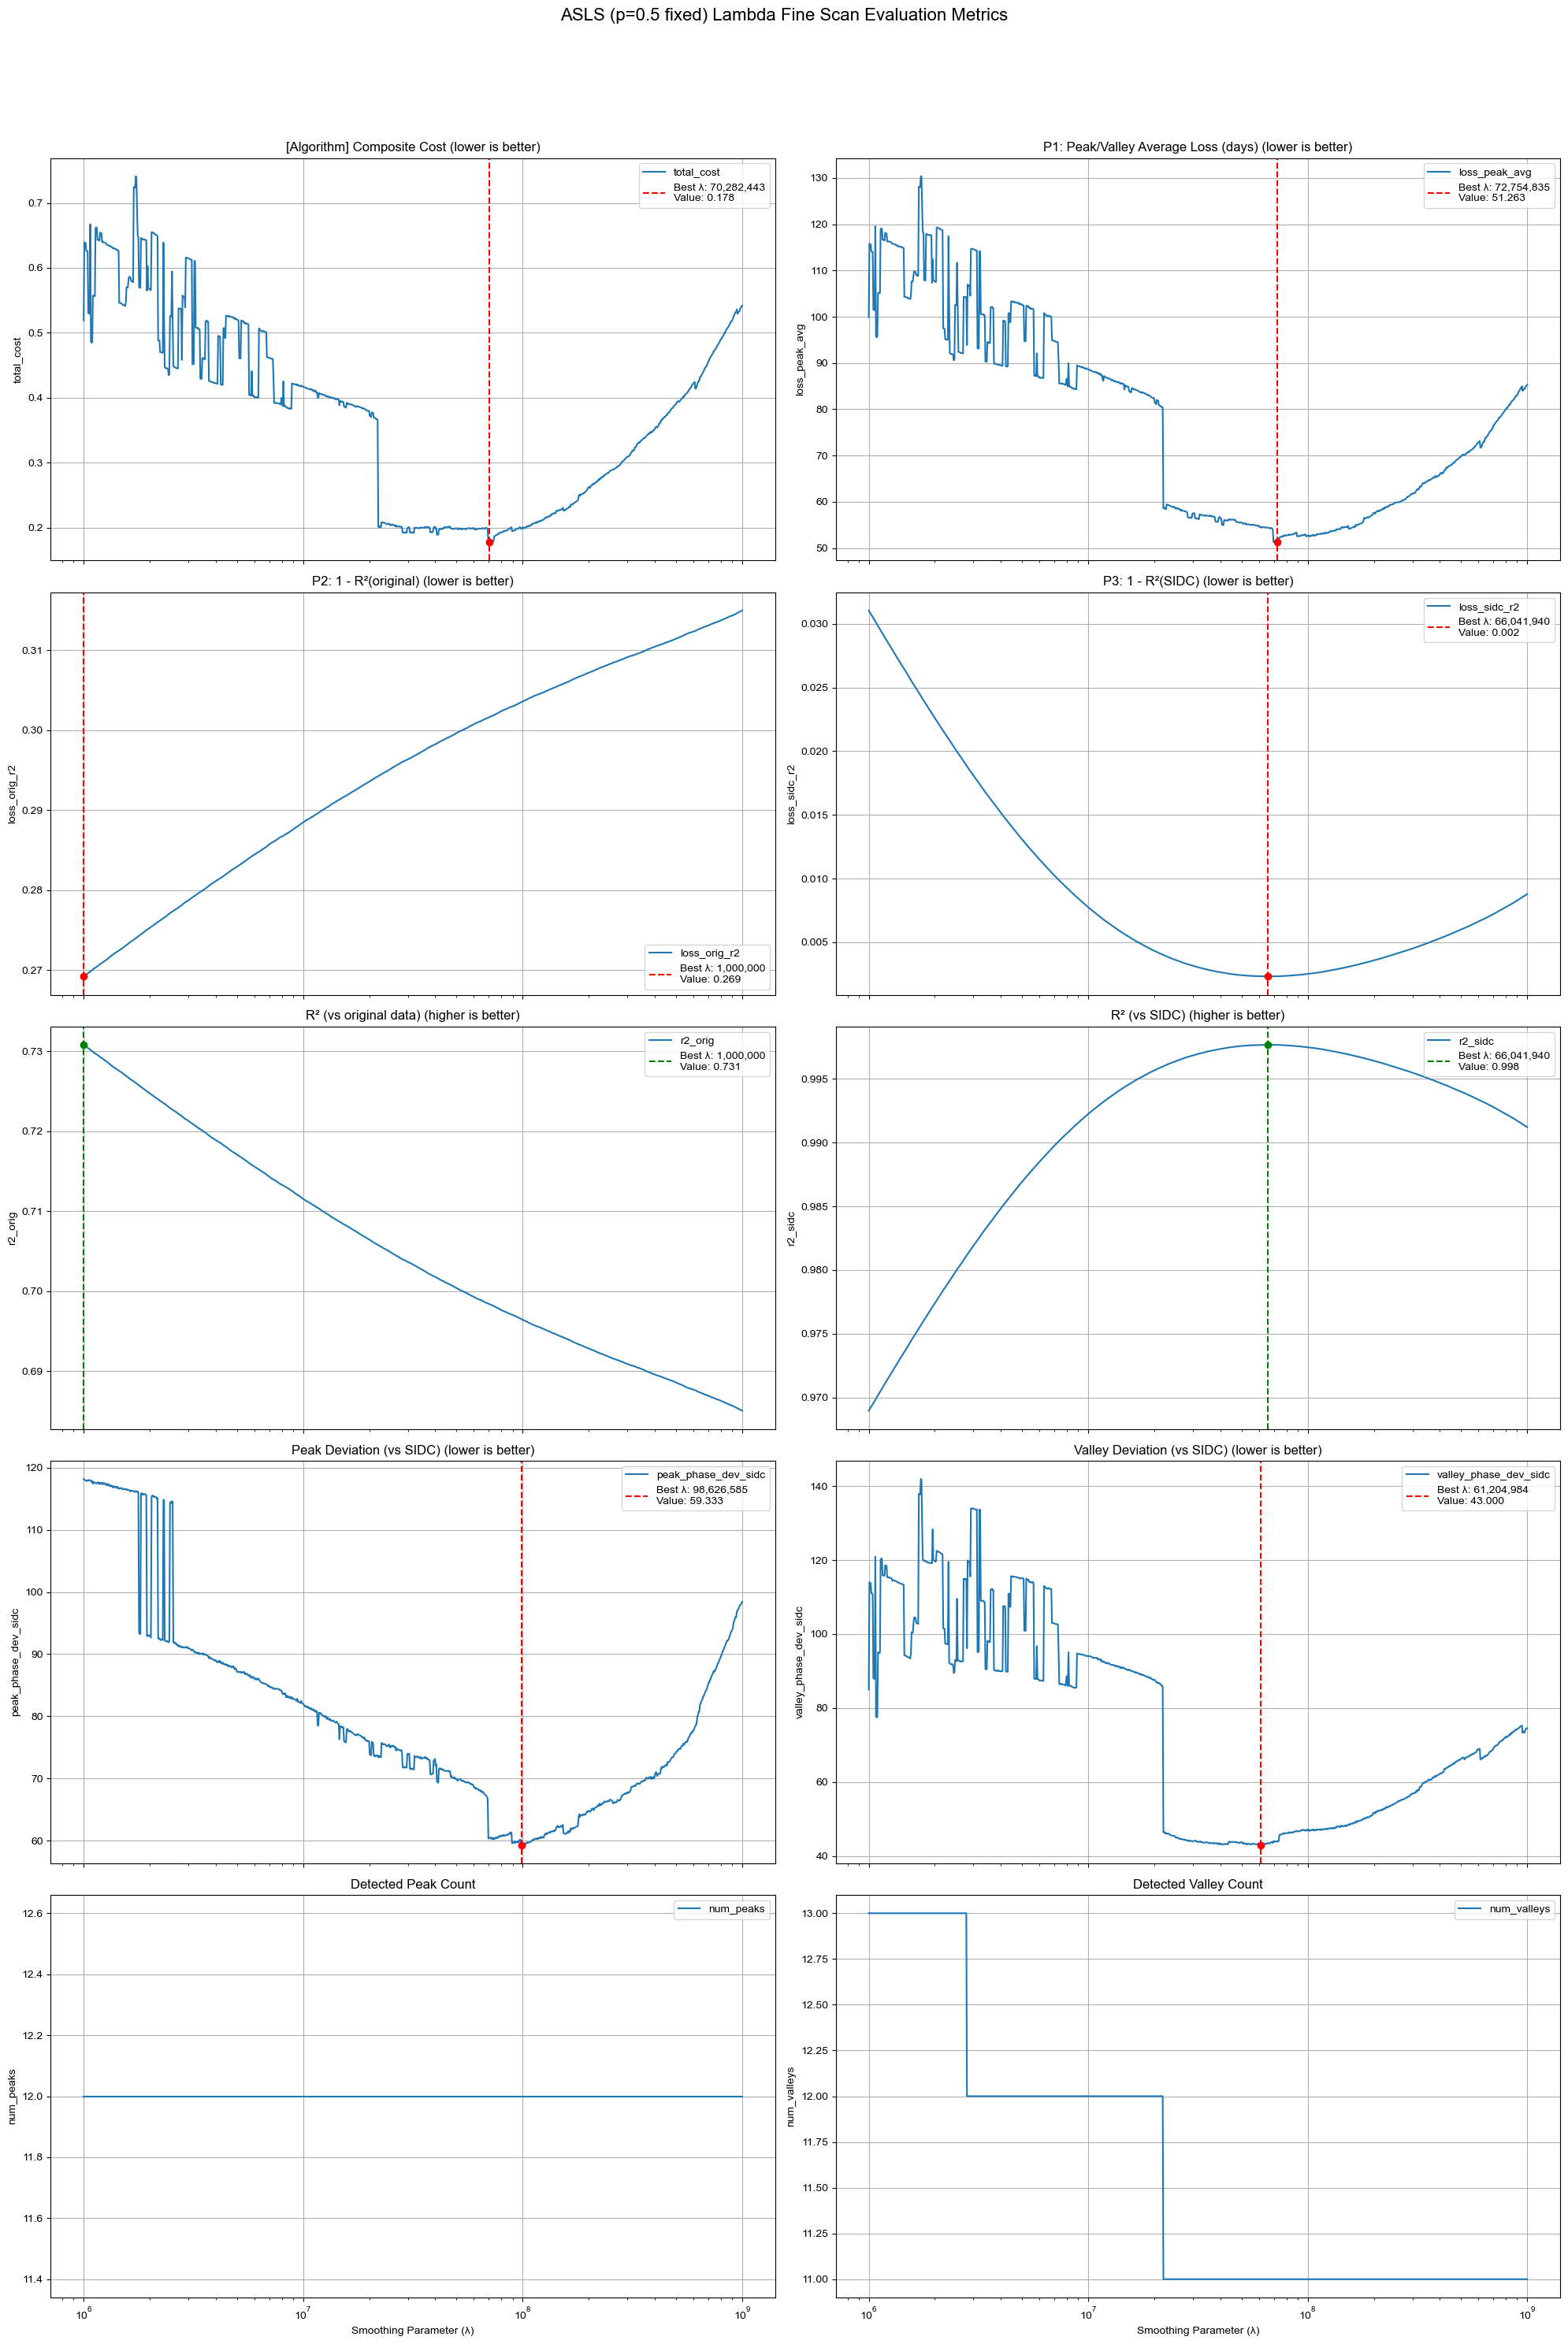


--- Step 5: Finding best Lambda (based on normalized composite cost algorithm) ---
🏆 [Algorithm Final Result] 🏆
  Best Lambda based on [Lowest Composite Cost]: 70,282,443

--- Detailed Metrics for Best Lambda (λ = 70,282,443) ---
p                          0.500000
r2_orig                    0.698390
rmse_orig                 43.236352
r2_sidc                    0.997686
rmse_sidc                  3.096604
peak_phase_dev_orig       78.166667
valley_phase_dev_orig    821.363636
peak_phase_dev_sidc       60.500000
valley_phase_dev_sidc     43.818182
num_peaks                 12.000000
num_valleys               11.000000
loss_peak_avg             51.325000
loss_orig_r2               0.301610
loss_sidc_r2               0.002314
norm_loss_peak             0.000790
norm_loss_orig             0.708245
norm_loss_sidc             0.000158
total_cost                 0.177559


--- For Reference Only: Best Values Based on Single Metrics ---
  (Reference) Best Lambda based on [Highest SIDC R2]: 6

In [15]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import interp1d
from scipy.signal import find_peaks
from sklearn.metrics import r2_score, mean_squared_error
# Import normalization tools
from sklearn.preprocessing import MinMaxScaler
# Import smoothing algorithm (assumes Cell 1 has been defined)
from pybaselines.whittaker import asls 
# Import Cell 1's deviation calculation function (assumes Cell 1 has been defined)
# from your_cell_1_file import calculate_deviation_vs_known_extrema
from tqdm.auto import tqdm # Use tqdm to display progress bar
import sys
import warnings


warnings.filterwarnings('ignore')

# --------------------------------------------------------------------------
# 0. Assumptions
# --------------------------------------------------------------------------
# Before running this cell, it is assumed that the previous cell (2D search) 
# has been successfully executed, and the following variables/functions 
# are defined in memory:
#
# Variables:
#   daily_series, sidc_daily_interp,
#   known_peaks, known_valleys, daily_peaks, daily_valleys
#
# Functions:
#   asls (from pybaselines)
#   calculate_deviation_vs_known_extrema (from Cell 1)
#
print("--- Preparation: Libraries and assumed functions/data are ready ---")


# --------------------------------------------------------------------------
# 1. Final optimized helper function (from your 'new version')
# --------------------------------------------------------------------------
def robust_find_peaks_valleys(smoothed_series, distance_days=365*8):
    """
    Robust peak/valley detection function (from your 'new version')
    Designed for smoothed curves, using fixed low prominence values.
    """
    try:
        # Use lower prominence values to adapt to smoothed data
        peaks_idx, _ = find_peaks(
            smoothed_series.values, 
            distance=distance_days, 
            prominence=0.5  # Fixed lower value
        )
        valleys_idx, _ = find_peaks(
            -smoothed_series.values, 
            distance=distance_days, 
            prominence=0.1  # Even lower requirement for valleys
        )
        
        df_peaks = pd.DataFrame({
            'date': smoothed_series.index[peaks_idx],
            'SSN': smoothed_series.iloc[peaks_idx]
        }).set_index('date')
        
        df_valleys = pd.DataFrame({
            'date': smoothed_series.index[valleys_idx],
            'SSN': smoothed_series.iloc[valleys_idx]
        }).set_index('date')
        
        return df_peaks, df_valleys
        
    except Exception as e:
        print(f"Peak/valley detection failed: {e}")
        return pd.DataFrame(), pd.DataFrame()

print("--- Helper function 'robust_find_peaks_valleys' defined ---")

# --------------------------------------------------------------------------
# 2. Define new search parameters and algorithm weights
# --------------------------------------------------------------------------
print("--- Step 1: Defining new search parameters and weights ---")
# In the first cell's grid search, p=0.5 was identified as optimal (or your chosen value)
p_fixed = 0.5 

# You can freely modify the range here
lam_values_fine = np.logspace(np.log10(1e6), np.log10(1e9), 1000) 
# lam_values_fine = np.logspace(5, 10, 500) # Or use the range from your new version

print(f"Fixed p = {p_fixed}")
print(f"Will search {len(lam_values_fine)} Lambda values (from {lam_values_fine.min():.0e} to {lam_values_fine.max():.0e})")

# --------------------------------------------------------------------------
# 3. Define algorithm weights (consistent with Cell 1)
# --------------------------------------------------------------------------
# P1 (most important): 60% weight for SIDC peak/valley matching
W_PEAK = 0.60  
# P2 (secondary): 25% weight for R²-original data
W_ORIG = 0.25
# P3 (balance): 15% weight for R²-SIDC trend
W_SIDC = 0.15
# [New] P4 (penalty): 10% weight for peak/valley count (optional, set to 0 for now)
# W_COUNT = 0.0 
# (Ensure W_PEAK + W_ORIG + W_SIDC = 1.0)

print(f"Algorithm weights: peaks/valleys={W_PEAK*100}%, original R²={W_ORIG*100}%, SIDC R²={W_SIDC*100}%")

# --------------------------------------------------------------------------
# 4. Execute fine search (merged final version)
# --------------------------------------------------------------------------
print("\n--- Step 2: Starting fine search ---")
results_fine = []

# Use tqdm to display loop progress
for lam in tqdm(lam_values_fine, desc=f"Processing Lambda (p={p_fixed})"):
    try:
        # 1. Run ASLS smoothing
        smoothed_data, _ = asls(daily_series.values, lam=lam, p=p_fixed)
        smoothed_series = pd.Series(smoothed_data, index=daily_series.index)

        # 2. Evaluate (vs SIDC and original)
        r2_sidc = r2_score(sidc_daily_interp.values, smoothed_data)
        rmse_sidc = np.sqrt(mean_squared_error(sidc_daily_interp.values, smoothed_data))
        r2_orig = r2_score(daily_series.values, smoothed_data)
        rmse_orig = np.sqrt(mean_squared_error(daily_series.values, smoothed_data))

        # 3. Call robust peak/valley detection
        smoothed_peaks, smoothed_valleys = robust_find_peaks_valleys(smoothed_series)
        
        # 4. Get peak/valley counts
        num_peaks = len(smoothed_peaks)
        num_valleys = len(smoothed_valleys)

        # 5. Evaluate phase (vs SIDC official points)
        peak_phase_dev_sidc = calculate_deviation_vs_known_extrema(smoothed_peaks, known_peaks)
        valley_phase_dev_sidc = calculate_deviation_vs_known_extrema(smoothed_valleys, known_valleys)
        
        # 6. Evaluate phase (vs original data peaks/valleys)
        peak_phase_dev_orig = calculate_deviation_vs_known_extrema(smoothed_peaks, daily_peaks)
        valley_phase_dev_orig = calculate_deviation_vs_known_extrema(smoothed_valleys, daily_valleys)

        # 7. Calculate three core losses (for algorithm preparation)
        
        # P1 loss: peak/valley average deviation (days)
        # Give higher weight to valleys
        W_PEAK_INTERNAL = 0.45  # Peaks account for 45% weight
        W_VALLEY_INTERNAL = 0.55  # Valleys account for 55% weight
        
        if np.isnan(peak_phase_dev_sidc) or np.isnan(valley_phase_dev_sidc):
            loss_peak_avg = np.nan # If either is nan, average is nan
        else:
            loss_peak_avg = (W_PEAK_INTERNAL * peak_phase_dev_sidc) + \
                            (W_VALLEY_INTERNAL * valley_phase_dev_sidc)
            
        # P2 loss: 1.0 - R²(original)
        loss_orig_r2 = 1.0 - r2_orig
        # P3 loss: 1.0 - R²(SIDC)
        loss_sidc_r2 = 1.0 - r2_sidc
        
        results_fine.append({
            'lambda': lam,
            'p': p_fixed,
            'r2_orig': r2_orig,
            'rmse_orig': rmse_orig,
            'r2_sidc': r2_sidc,
            'rmse_sidc': rmse_sidc,
            'peak_phase_dev_orig': peak_phase_dev_orig,
            'valley_phase_dev_orig': valley_phase_dev_orig,
            'peak_phase_dev_sidc': peak_phase_dev_sidc,
            'valley_phase_dev_sidc': valley_phase_dev_sidc,
            # Add peak/valley counts
            'num_peaks': num_peaks,
            'num_valleys': num_valleys,
            # Add original loss values
            'loss_peak_avg': loss_peak_avg,
            'loss_orig_r2': loss_orig_r2,
            'loss_sidc_r2': loss_sidc_r2
        })
        
    except Exception as e:
        # Handle errors that may occur during smoothing or peak finding
        results_fine.append({
            'lambda': lam, 'p': p_fixed, 
            'r2_orig': np.nan, 'rmse_orig': np.nan,
            'r2_sidc': np.nan, 'rmse_sidc': np.nan,
            'peak_phase_dev_orig': np.nan, 'valley_phase_dev_orig': np.nan,
            'peak_phase_dev_sidc': np.nan, 'valley_phase_dev_sidc': np.nan,
            'num_peaks': 0, 'num_valleys': 0,
            'loss_peak_avg': np.nan, 'loss_orig_r2': np.nan, 'loss_sidc_r2': np.nan
        })

print("\n--- Step 3: Search completed, starting algorithm and visualization ---")

# --------------------------------------------------------------------------
# 5. Apply normalized composite cost algorithm
# --------------------------------------------------------------------------
if not results_fine:
    print("Error: Fine search has no valid results.")
    # sys.exit()
else:
    # [IMPORTANT] Drop rows where loss cannot be calculated before normalization (e.g., peak/valley matching failed)
    results_df_new = pd.DataFrame(results_fine).dropna(
        subset=['loss_peak_avg', 'loss_orig_r2', 'loss_sidc_r2']
    ).set_index('lambda')
    print(f"Total {len(results_fine)} results, {len(results_df_new)} valid results for algorithm analysis.")


if results_df_new.empty:
    print("Error: All fine search combinations failed to calculate metrics.")
    # sys.exit()
else:
    # --- 1. Normalization ---
    scaler = MinMaxScaler()
    results_df_new['norm_loss_peak'] = scaler.fit_transform(results_df_new[['loss_peak_avg']])
    results_df_new['norm_loss_orig'] = scaler.fit_transform(results_df_new[['loss_orig_r2']])
    results_df_new['norm_loss_sidc'] = scaler.fit_transform(results_df_new[['loss_sidc_r2']])

    # --- 2. Calculate final "composite cost" ---
    results_df_new['total_cost'] = (
        results_df_new['norm_loss_peak'] * W_PEAK +
        results_df_new['norm_loss_orig'] * W_ORIG +
        results_df_new['norm_loss_sidc'] * W_SIDC
    )
    print("Normalized composite cost (total_cost) calculation completed.")


# --------------------------------------------------------------------------
# 6. Analyze and visualize fine search results
# --------------------------------------------------------------------------
print("--- Step 4: Plotting line charts ---")
# Create 5x2 plot
fig, axes = plt.subplots(5, 2, figsize=(20, 30), sharex=True)
fig.suptitle(f'ASLS (p={p_fixed} fixed) Lambda Fine Scan Evaluation Metrics', fontsize=16, y=1.02)
plt.xscale('log')

# Define columns and titles to plot (added num_peaks/valleys)
plot_metrics = {
    'total_cost': '[Algorithm] Composite Cost (lower is better)',
    'loss_peak_avg': 'P1: Peak/Valley Average Loss (days) (lower is better)',
    'loss_orig_r2': 'P2: 1 - R²(original) (lower is better)',
    'loss_sidc_r2': 'P3: 1 - R²(SIDC) (lower is better)',
    'r2_orig': 'R² (vs original data) (higher is better)',
    'r2_sidc': 'R² (vs SIDC) (higher is better)',
    'peak_phase_dev_sidc': 'Peak Deviation (vs SIDC) (lower is better)',
    'valley_phase_dev_sidc': 'Valley Deviation (vs SIDC) (lower is better)',
    # From 'new version' auxiliary metrics
    'num_peaks': 'Detected Peak Count',
    'num_valleys': 'Detected Valley Count'
}

# Flatten axes array for iteration
ax_flat = axes.flatten()

# Iterate and plot all charts
for i, (metric, title) in enumerate(plot_metrics.items()):
    if metric in results_df_new.columns:
        ax = ax_flat[i]
        results_df_new[metric].plot(ax=ax, grid=True)
        
        # Mark best point
        if "lower is better" in title:
            best_idx = results_df_new[metric].idxmin()
            color = 'r'
        elif "higher is better" in title:
            best_idx = results_df_new[metric].idxmax()
            color = 'g'
        else: # Count plot, don't mark best
            best_idx = None
            
        if best_idx is not None:
            best_val = results_df_new[metric].loc[best_idx]
            ax.axvline(best_idx, color=color, linestyle='--', label=f'Best λ: {best_idx:,.0f}\nValue: {best_val:.3f}')
            ax.plot(best_idx, best_val, color+'o')
        
        ax.set_title(title, fontsize=12)
        ax.set_ylabel(metric)
        ax.set_xlabel('Smoothing Parameter (λ)')
        ax.legend(loc='best')

plt.tight_layout(rect=[0, 0.03, 1, 0.98])

# --- Step 7: Save image ---
# plot_filename = 'lambda_scan_p0.5_line_plots_FINAL_ALGORITHM.png'
# plt.savefig(plot_filename, dpi=150)
# print(f"Image saved to: {plot_filename}")
plt.show()

# --------------------------------------------------------------------------
# 8. Find best Lambda
# --------------------------------------------------------------------------
print("\n--- Step 5: Finding best Lambda (based on normalized composite cost algorithm) ---")

try:
    # --- Primary Result ---
    # 1. Find best Lambda with lowest composite cost
    best_lambda_cost = results_df_new['total_cost'].idxmin()
    print(f"🏆 [Algorithm Final Result] 🏆")
    print(f"  Best Lambda based on [Lowest Composite Cost]: {best_lambda_cost:,.0f}")
    
    print(f"\n--- Detailed Metrics for Best Lambda (λ = {best_lambda_cost:,.0f}) ---")
    print(results_df_new.loc[best_lambda_cost].to_string())
    # --- /Primary Result ---
    

    print("\n\n--- For Reference Only: Best Values Based on Single Metrics ---")
    # Best R2 (SIDC)
    best_lambda_r2_sidc = results_df_new['r2_sidc'].idxmax()
    print(f"  (Reference) Best Lambda based on [Highest SIDC R2]: {best_lambda_r2_sidc:,.0f}")
    
    # Best RMSE (SIDC)
    best_lambda_rmse_sidc = results_df_new['rmse_sidc'].idxmin()
    print(f"  (Reference) Best Lambda based on [Lowest SIDC RMSE]: {best_lambda_rmse_sidc:,.0f}")
    
    # Best P1 loss (peaks/valleys)
    best_lambda_peak_loss = results_df_new['loss_peak_avg'].idxmin()
    print(f"  (Reference) Best Lambda based on [Lowest Peak/Valley Loss]: {best_lambda_peak_loss:,.0f}")


except KeyError as e:
    print(f"Error: Unable to find metric {e}, possibly all values are NaT or NaN during search.")
except ValueError as e:
    print(f"Error finding best value (possibly empty data): {e}")

print("\nAnalysis completed. Please check the saved image and the 🏆 Algorithm Final Result 🏆 output above.")


## Display trend line with confirmed parameters

Data loading and truncation successful.
--- Step 1b: Interpolating SIDC monthly data to daily frequency... ---
SIDC data interpolation completed.
--- Step 2: Performing smoothing with input parameters... ---

Comprehensive Evaluation Results (λ=70000000.0)

1. Goodness of Fit Metrics:
----------------------------------------
                                   vs Original Daily Data  vs SIDC Interpolated Data  SIDC vs Original Data
R² (Coefficient of Determination)                0.698691                   0.997692               0.692967
MAE (Mean Absolute Error)                       31.240324                   2.384037              31.659898
RMSE (Root Mean Square Error)                   43.205007                   3.093093              43.613408

2. Peak Deviation Analysis:
----------------------------------------
                           vs Original Data Peaks  vs Known Cycle Peaks
Average Deviation (days)                     78.0                  60.3
Maximum Deviation (days)   

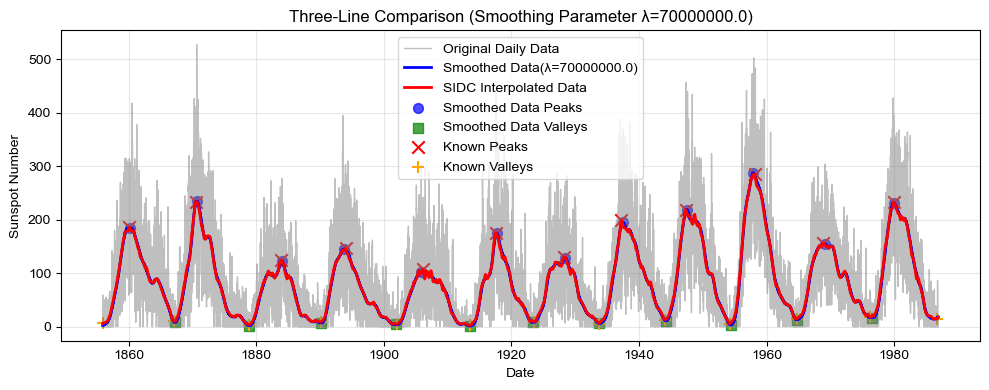

Script execution completed.


In [16]:
# ---------------------------------------------------------------------------
# Import all required Python libraries
# ---------------------------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pybaselines.whittaker import asls
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy.signal import find_peaks

# ---------------------------------------------------------------------------
# 1. Global Configuration and Helper Functions
# ---------------------------------------------------------------------------
# --- User-defined parameters ---
START_DATE = '1855-12-01'
END_DATE = '1986-12-01'

def find_peaks_valleys(
    data_series: pd.Series,
    distance_days: int = 365 * 8,  # Recommended: 8 years
    prominence_peaks: int = 40,    # Recommended: 40
    prominence_valleys: int = 5    # Recommended: 5
):
    """
    Improved version: Use different prominence parameters for peaks and valleys.
    Find significant peaks and valleys in time series data.

    Args:
        data_series (pd.Series): Time series data to analyze (e.g., smoothed sunspot number).
        distance_days (int, optional): Minimum horizontal distance between adjacent peaks/valleys (days). Default 8 years.
        prominence_peaks (int, optional): Prominence of peaks.
        prominence_valleys (int, optional): Prominence of valleys.

    Returns:
        tuple[pd.DataFrame, pd.DataFrame]: Two DataFrames containing peak and valley information.
    """
    # Find peaks using peak-specific parameters
    peaks_idx, _ = find_peaks(data_series, distance=distance_days, prominence=prominence_peaks)
    df_peaks = pd.DataFrame({
        'date': data_series.index[peaks_idx],
        'SSN': data_series.iloc[peaks_idx]
    }).set_index('date')

    # Find valleys using valley-specific parameters
    valleys_idx, _ = find_peaks(-data_series, distance=distance_days, prominence=prominence_valleys)
    df_valleys = pd.DataFrame({
        'date': data_series.index[valleys_idx],
        'SSN': data_series.iloc[valleys_idx]
    }).set_index('date')

    return df_peaks, df_valleys
    

def calculate_deviation(model_extrema: pd.DataFrame, known_extrema: pd.DataFrame):
    """
    Calculate phase (time) deviation between model-detected extrema and known extrema.
    """
    if model_extrema.empty or known_extrema.empty:
        return pd.DataFrame()
    
    left_df = model_extrema.sort_index().reset_index().rename(columns={'date': 'model_date'})
    right_df = known_extrema.sort_index().reset_index().rename(columns={'date': 'known_date'})
    
    merged_df = pd.merge_asof(
        left_df, right_df,
        left_on='model_date', right_on='known_date',
        direction='nearest', tolerance=pd.Timedelta(days=365 * 5.5)
    ).dropna()

    if merged_df.empty:
        return pd.DataFrame()

    merged_df['phase_deviation_days'] = (merged_df['model_date'] - merged_df['known_date']).dt.days
    return merged_df

# ---------------------------------------------------------------------------
# 2. Data Loading and Preprocessing
# ---------------------------------------------------------------------------
try:
    # [Note] Path is relative to the notebook
    daily_df = pd.read_csv('../../data/ready/ssn_daily_1849_2025.csv')
    daily_df['date'] = pd.to_datetime(daily_df['date'])
    daily_df.set_index('date', inplace=True)
    daily_df.rename(columns={'ssn': 'sunspot_number'}, inplace=True)
    daily_df = daily_df.loc[START_DATE:END_DATE]
    daily_series = daily_df['sunspot_number'][daily_df['sunspot_number'] != -1]

    monthly_df = pd.read_csv('../../data/ready/ssn_smoothed_monthly_1749_2025.csv')
    monthly_df['date'] = pd.to_datetime(monthly_df['Year'].astype(int).astype(str) + '-' + monthly_df['Month'].astype(int).astype(str) + '-01')
    monthly_df.set_index('date', inplace=True)
    monthly_df.rename(columns={'SSN': 'smoothed_number'}, inplace=True)
    monthly_df = monthly_df.loc[START_DATE:END_DATE]
    monthly_sidc = monthly_df['smoothed_number'][monthly_df['smoothed_number'] != -1]

    df_solar_cycle = pd.read_csv('../../data/ready/solar_cycle_minmax.csv')
    known_peaks = df_solar_cycle.dropna(subset=['Max']).set_index(pd.to_datetime(df_solar_cycle['Max']))[['Max_SSN']].rename(columns={'Max_SSN': 'SSN'})
    known_valleys = df_solar_cycle.dropna(subset=['start_Min']).set_index(pd.to_datetime(df_solar_cycle['start_Min']))[['Min_SSN']].rename(columns={'Min_SSN': 'SSN'})
    known_peaks.index.name = 'date'
    known_valleys.index.name = 'date'
    known_peaks = known_peaks.loc[START_DATE:END_DATE]
    known_valleys = known_valleys.loc[START_DATE:END_DATE]

    
    # Truncate all data to specified time range
    daily_df = daily_df.loc[START_DATE:END_DATE]
    monthly_df = monthly_df.loc[START_DATE:END_DATE]
    known_peaks = known_peaks.loc[START_DATE:END_DATE]
    known_valleys = known_valleys.loc[START_DATE:END_DATE]
    print("Data loading and truncation successful.")

    # --- New: Interpolate SIDC monthly data to daily frequency ---
    print("--- Step 1b: Interpolating SIDC monthly data to daily frequency... ---")
    # 1. Resample to daily ('D')
    # 2. Use linear interpolation ('linear') to fill ('cubic' spline interpolation is also possible for smoother results)
    sidc_daily_interpolated = monthly_df['smoothed_number'].resample('D').interpolate(method='linear')
    # 3. Reindex to match daily data index (ensure dates are fully aligned, handling missing days in original data)
    sidc_daily_interpolated = sidc_daily_interpolated.reindex(daily_df.index)
    print("SIDC data interpolation completed.")


except Exception as e:
    print(f"Error during data loading or interpolation: {e}")
    exit()

# ---------------------------------------------------------------------------
# 3. Set smoothing parameters
# ---------------------------------------------------------------------------
# Hardcoded parameter values here, uncomment the line below for user input
user_lambda = 7e7
# user_lambda = float(input("Enter smoothing parameter λ (e.g., 8.8e6): "))

# ---------------------------------------------------------------------------
# 4. Perform smoothing with user-input parameters
# ---------------------------------------------------------------------------
print("--- Step 2: Performing smoothing with input parameters... ---")
daily_series = daily_df['sunspot_number']

try:
    smoothed_data, params = asls(daily_series.values, lam=user_lambda, p=0.5)
    smoothed_series = pd.Series(smoothed_data, index=daily_series.index)
    
    # Extract peaks and valleys from original daily data
    daily_peaks, daily_valleys = find_peaks_valleys(daily_series)
    
    # Extract peaks and valleys from smoothed data
    smoothed_peaks, smoothed_valleys = find_peaks_valleys(smoothed_series)
    
    # Calculate peak and valley deviations
    peak_dev_daily = calculate_deviation(smoothed_peaks, daily_peaks)
    valley_dev_daily = calculate_deviation(smoothed_valleys, daily_valleys)
    peak_dev_known = calculate_deviation(smoothed_peaks, known_peaks)
    valley_dev_known = calculate_deviation(smoothed_valleys, known_valleys)
    
    # --- Metric calculation (using aligned data) ---
    
    # Find common index for all Series (original, smoothed, SIDC interpolated)
    common_index = daily_series.index.intersection(smoothed_series.index).intersection(sidc_daily_interpolated.index)
    
    # Align data based on common index
    daily_aligned = daily_series.loc[common_index]
    smoothed_aligned = smoothed_series.loc[common_index]
    sidc_aligned = sidc_daily_interpolated.loc[common_index].dropna() # Interpolated data may have NaN, remove them
    
    # Re-align (because sidc_aligned may have removed NaN)
    common_index = daily_aligned.index.intersection(sidc_aligned.index)
    daily_aligned = daily_aligned.loc[common_index]
    smoothed_aligned = smoothed_aligned.loc[common_index]
    sidc_aligned = sidc_aligned.loc[common_index]
    
    # Calculate evaluation metrics vs original daily data
    r2_daily = r2_score(daily_aligned, smoothed_aligned)
    mae_daily = mean_absolute_error(daily_aligned, smoothed_aligned)
    rmse_daily = np.sqrt(mean_squared_error(daily_aligned, smoothed_aligned))
    
    # Calculate evaluation metrics vs SIDC interpolated daily data
    r2_sidc = r2_score(sidc_aligned, smoothed_aligned)
    mae_sidc = mean_absolute_error(sidc_aligned, smoothed_aligned)
    rmse_sidc = np.sqrt(mean_squared_error(sidc_aligned, smoothed_aligned))

    # Calculate evaluation metrics: SIDC interpolated data vs original daily data
    r2_sidc_vs_original = r2_score(daily_aligned, sidc_aligned)
    mae_sidc_vs_original = mean_absolute_error(daily_aligned, sidc_aligned)
    rmse_sidc_vs_original = np.sqrt(mean_squared_error(daily_aligned, sidc_aligned))
    
    # --- New: Print all evaluation results in table format ---
    print("\n" + "=" * 60)
    print(f"Comprehensive Evaluation Results (λ={user_lambda})")
    print("=" * 60)
    
    # 1. Goodness of fit table

    metrics_data = {
        'vs Original Daily Data': [r2_daily, mae_daily, rmse_daily],
        'vs SIDC Interpolated Data': [r2_sidc, mae_sidc, rmse_sidc],
        'SIDC vs Original Data': [r2_sidc_vs_original, mae_sidc_vs_original, rmse_sidc_vs_original]
    }
    metrics_index = ['R² (Coefficient of Determination)', 'MAE (Mean Absolute Error)', 'RMSE (Root Mean Square Error)']
    df_metrics = pd.DataFrame(metrics_data, index=metrics_index)
    
    print(f"\n1. Goodness of Fit Metrics:")
    print("-" * 40)
    # Use to_string to ensure alignment
    print(df_metrics.to_string(float_format="%.6f"))

    # 2. Peak/valley deviation table
    peak_dev_data = {
        'vs Original Data Peaks': [
            abs(peak_dev_daily['phase_deviation_days']).mean() if not peak_dev_daily.empty else np.nan,
            abs(peak_dev_daily['phase_deviation_days']).max() if not peak_dev_daily.empty else np.nan,
            abs(peak_dev_daily['phase_deviation_days']).std() if not peak_dev_daily.empty else np.nan,
            len(peak_dev_daily)
        ],
        'vs Known Cycle Peaks': [
            abs(peak_dev_known['phase_deviation_days']).mean() if not peak_dev_known.empty else np.nan,
            abs(peak_dev_known['phase_deviation_days']).max() if not peak_dev_known.empty else np.nan,
            abs(peak_dev_known['phase_deviation_days']).std() if not peak_dev_known.empty else np.nan,
            len(peak_dev_known)
        ]
    }
    valley_dev_data = {
        'vs Original Data Valleys': [
            abs(valley_dev_daily['phase_deviation_days']).mean() if not valley_dev_daily.empty else np.nan,
            abs(valley_dev_daily['phase_deviation_days']).max() if not valley_dev_daily.empty else np.nan,
            abs(valley_dev_daily['phase_deviation_days']).std() if not valley_dev_daily.empty else np.nan,
            len(valley_dev_daily)
        ],
        'vs Known Cycle Valleys': [
            abs(valley_dev_known['phase_deviation_days']).mean() if not valley_dev_known.empty else np.nan,
            abs(valley_dev_known['phase_deviation_days']).max() if not valley_dev_known.empty else np.nan,
            abs(valley_dev_known['phase_deviation_days']).std() if not valley_dev_known.empty else np.nan,
            len(valley_dev_known)
        ]
    }
    dev_index = ['Average Deviation (days)', 'Maximum Deviation (days)', 'Standard Deviation (days)', 'Match Count']
    df_peak_dev = pd.DataFrame(peak_dev_data, index=dev_index)
    df_valley_dev = pd.DataFrame(valley_dev_data, index=dev_index)

    print(f"\n2. Peak Deviation Analysis:")
    print("-" * 40)
    print(df_peak_dev.to_string(float_format="%.1f"))
    print(f"\n3. Valley Deviation Analysis:")
    print("-" * 40)
    print(df_valley_dev.to_string(float_format="%.1f"))

    # 4. Extrema statistics table
    count_data = {
        'Peak Count': [len(daily_peaks), len(smoothed_peaks), len(known_peaks)],
        'Valley Count': [len(daily_valleys), len(smoothed_valleys), len(known_valleys)]
    }
    count_index = ['Original Daily Data', 'Smoothed Data', 'Known Solar Cycles']
    df_counts = pd.DataFrame(count_data, index=count_index)
    
    print(f"\n4. Extrema Statistics:")
    print("-" * 40)
    print(df_counts.to_string())
    print("\n" + "=" * 60)

    # ---------------------------------------------------------------------------
    # 6. (New) Save data to CSV
    # ---------------------------------------------------------------------------
    print("\n--- Step 3: Preparing and saving data to CSV... ---")
    
    # Use the aligned Series from previous steps
    df_to_save = pd.DataFrame({
        'original_ssn': daily_aligned,
        'sidc_interpolated_ssn': sidc_aligned,
        'trend_ssn': smoothed_aligned
    })
    
    # Rename index to 'date' to display as first column in CSV
    df_to_save.index.name = 'date'
    
    # output_filename = '2.4_01平滑参数结果.csv'
    # df_to_save.to_csv(output_filename)
    # print(f"Data successfully saved to {output_filename}")
    print("CSV save commented out")

except Exception as e:
    print(f"Error during smoothing or evaluation: {e}")
    exit()

# ---------------------------------------------------------------------------
# 5. Plot three-line comparison chart (now Step 4)
# ---------------------------------------------------------------------------
print("\n--- Step 4: Plotting three-line comparison chart... ---")
plt.figure(figsize=(10, 4))

# Plot three curves
plt.plot(daily_series.index, daily_series.values, 'gray', alpha=0.5, label='Original Daily Data', linewidth=1)
plt.plot(smoothed_series.index, smoothed_series.values, 'b-', label=f'Smoothed Data(λ={user_lambda})', linewidth=2)
# Update: Use interpolated SIDC data
plt.plot(sidc_daily_interpolated.index, sidc_daily_interpolated.values, 'r-', label='SIDC Interpolated Data', linewidth=2)

# Mark extrema
if not smoothed_peaks.empty:
    plt.scatter(smoothed_peaks.index, smoothed_peaks['SSN'], color='blue', s=50, marker='o', label='Smoothed Data Peaks', alpha=0.7)
if not smoothed_valleys.empty:
    plt.scatter(smoothed_valleys.index, smoothed_valleys['SSN'], color='green', s=50, marker='s', label='Smoothed Data Valleys', alpha=0.7)
if not known_peaks.empty:
    plt.scatter(known_peaks.index, known_peaks['SSN'], color='red', s=80, marker='x', label='Known Peaks')
if not known_valleys.empty:
    plt.scatter(known_valleys.index, known_valleys['SSN'], color='orange', s=80, marker='+', label='Known Valleys')

# Set chart properties
plt.xlabel('Date')
plt.ylabel('Sunspot Number')
plt.title(f'Three-Line Comparison (Smoothing Parameter λ={user_lambda})')
plt.legend()
plt.grid(True, alpha=0.3)

# Display chart
plt.tight_layout()
plt.show()

print("Script execution completed.")
